In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.feature_selection import RFECV

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Seen from https://www.kaggle.com/kabure/almost-complete-feature-engineering-ieee-data#V-Features
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        # print(name)
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [3]:
df_identity_train = pd.read_csv("../Data/train_identity.csv")
df_transaction_train = pd.read_csv("../Data/train_transaction.csv")
df_identity_test = pd.read_csv("../Data/test_identity.csv")
df_transaction_test = pd.read_csv("../Data/test_transaction.csv")
df_train = pd.merge(df_transaction_train, df_identity_train, how = "left", on = "TransactionID")
df_test = pd.merge(df_transaction_test, df_identity_test, how = "left", on = "TransactionID")

In [4]:
pd.set_option("display.max_rows", 500)

In [5]:
print("shape of df_identity_train: ", df_identity_train.shape)
print("shape of df_transaction_train: ", df_transaction_train.shape)
print("shape of df_train: ", df_train.shape)

shape of df_identity_train:  (144233, 41)
shape of df_transaction_train:  (590540, 394)
shape of df_train:  (590540, 434)


In [6]:
del df_identity_train, df_transaction_train, df_identity_test, df_transaction_test

In [7]:
for col in df_test.columns:
    if df_test[col].dtype != 'object':
        print(col, df_train[col].min(), df_test[col].min(), df_train[col].max(), df_test[col].max())

TransactionID 2987000 3663549 3577539 4170239
TransactionDT 86400 18403224 15811131 34214345
TransactionAmt 0.251 0.018000000000000002 31937.391 10270.0
card1 1000 1001 18396 18397
card2 100.0 100.0 600.0 600.0
card3 100.0 100.0 231.0 232.0
card5 100.0 100.0 237.0 237.0
addr1 100.0 100.0 540.0 540.0
addr2 10.0 10.0 102.0 102.0
dist1 0.0 0.0 10286.0 8081.0
dist2 0.0 0.0 11623.0 9213.0
C1 0.0 0.0 4685.0 2950.0
C2 0.0 0.0 5691.0 3275.0
C3 0.0 0.0 26.0 31.0
C4 0.0 0.0 2253.0 1601.0
C5 0.0 0.0 349.0 376.0
C6 0.0 0.0 2253.0 1601.0
C7 0.0 0.0 2255.0 1621.0
C8 0.0 0.0 3331.0 1005.0
C9 0.0 0.0 210.0 572.0
C10 0.0 0.0 3257.0 881.0
C11 0.0 0.0 3188.0 2234.0
C12 0.0 0.0 3188.0 2234.0
C13 0.0 0.0 2918.0 1562.0
C14 0.0 0.0 1429.0 797.0
D1 0.0 0.0 640.0 641.0
D2 0.0 0.0 640.0 641.0
D3 0.0 0.0 819.0 1076.0
D4 -122.0 0.0 869.0 1091.0
D5 0.0 0.0 819.0 1088.0
D6 -83.0 0.0 873.0 1091.0
D7 0.0 0.0 843.0 1088.0
D8 0.0 0.0 1707.7916259765625 2029.5833740234373
D9 0.0 0.0 0.9583330154418944 0.9583330154418944

V310 0.0 0.0 55125.0 167200.0
V311 0.0 0.0 55125.0 64800.0
V312 0.0 0.0 55125.0 167200.0
V313 0.0 0.0 4817.47021484375 4727.9599609375
V314 0.0 0.0 7519.8701171875 7539.75
V315 0.0 0.0 4817.47021484375 4727.9599609375
V316 0.0 0.0 93736.0 718740.0
V317 0.0 0.0 134021.0 958320.0
V318 0.0 0.0 98476.0 718740.0
V319 0.0 0.0 104060.0 453750.0
V320 0.0 0.0 104060.0 605000.0
V321 0.0 0.0 104060.0 605000.0
V322 0.0 0.0 880.0 86.0
V323 0.0 0.0 1411.0 128.0
V324 0.0 0.0 976.0 108.0
V325 0.0 0.0 12.0 8.0
V326 0.0 0.0 44.0 44.0
V327 0.0 0.0 18.0 31.0
V328 0.0 0.0 15.0 85.0
V329 0.0 0.0 99.0 125.0
V330 0.0 0.0 55.0 106.0
V331 0.0 0.0 160000.0 1040657.5
V332 0.0 0.0 160000.0 1040657.5
V333 0.0 0.0 160000.0 1040657.5
V334 0.0 0.0 55125.0 64800.0
V335 0.0 0.0 55125.0 64800.0
V336 0.0 0.0 55125.0 64800.0
V337 0.0 0.0 104060.0 375000.0
V338 0.0 0.0 104060.0 612500.0
V339 0.0 0.0 104060.0 612500.0
id_01 -100.0 -100.0 0.0 0.0
id_02 1.0 2.0 999595.0 999869.0
id_03 -13.0 -12.0 10.0 11.0
id_04 -28.0 -19.0 0.

In [8]:
one_val_cols =      [col for col in df_train.columns if df_train[col].nunique()<=1] +\
                        [col for col in df_test.columns if df_test[col].nunique()<=1]
missing_val_cols =  [col for col in df_train.columns if df_train[col].isnull().sum()/df_train.shape[0]>0.9] +\
                        [col for col in df_test.columns if df_test[col].isnull().sum()/df_test.shape[0]>0.9]
same_val_cols =     [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9] +\
                        [col for col in df_test.columns if df_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_to_drop = list(set(one_val_cols + missing_val_cols + same_val_cols))
print(cols_to_drop)


['V286', 'id_25', 'id_27', 'dist2', 'isFraud', 'V319', 'V124', 'V26', 'V101', 'V88', 'V118', 'V296', 'V284', 'V65', 'V119', 'V134', 'V316', 'V89', 'id_18', 'V293', 'V14', 'V123', 'id_07', 'V27', 'V28', 'V104', 'V121', 'V320', 'id_08', 'V115', 'V281', 'id_24', 'V297', 'V107', 'V98', 'V137', 'V309', 'V116', 'V68', 'V113', 'V103', 'V290', 'V136', 'V318', 'V25', 'D7', 'V135', 'V117', 'V132', 'V66', 'V321', 'V77', 'V299', 'V114', 'V122', 'V125', 'V120', 'V301', 'V105', 'id_22', 'V133', 'V110', 'V129', 'C3', 'id_21', 'V23', 'V298', 'V311', 'V55', 'V305', 'V112', 'V106', 'V102', 'V295', 'V86', 'V108', 'id_23', 'V109', 'V24', 'V300', 'V111', 'id_26', 'V67']


In [9]:
cols_to_drop.remove('isFraud')

In [ ]:
len(cols_to_drop)

In [ ]:
print(df_train["id_30"].dtype)

In [10]:
df_train.drop(cols_to_drop, axis = 1, inplace = True)
df_test.drop(cols_to_drop, axis = 1, inplace = True)

In [11]:
df_train.fillna(-999, inplace = True)
df_test.fillna(-999, inplace = True)

In [ ]:
resumetable(df_train)

In [12]:
def make_day_feature(df, offset=0.58, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6.
    """
    days = df[tname] / (3600 * 24)
    encoded_days = np.floor(days - 1 + offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23.
    """
    hours = df[tname] / (3600)
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [13]:
df_train["Weekday"] = make_day_feature(df_train)
df_train["Hour"]= make_hour_feature(df_train)
df_test["Weekday"] = make_day_feature(df_test)
df_test["Hour"] = make_hour_feature(df_test)

In [ ]:
df_train.dtypes

In [14]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 
          'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 
          'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
          'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 
          'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple',
          -999:"undefined"}
us_emails = ['gmail', 'net', 'edu']
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest_df-579654
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_pre'] = df_train[col].map(emails)
    df_test[col + '_pre'] = df_test[col].map(emails)
    
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])
    
    df_train[col + '_suffix'] = df_train[col + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[col + '_suffix'] = df_test[col + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')


In [15]:
df_train["P_emaildomain_suffix"].unique()

array(['-999', 'com', 'us', 'mx', 'es', 'de', 'fr', 'uk', 'jp'],
      dtype=object)

In [ ]:
for col in df_train.columns:
    if col.startswith("id"):
        print(col, df_train[col].nunique())
        if df_train[col].dtype!='object':
            print(df_train[col].nunique(), sorted(df_train[col].unique())[:10])

In [ ]:
df_train.columns[-50:]

In [16]:
categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain", "R_emaildomain"] +  ["M" + str(i) for i in range(1, 10)] +\
                    ['DeviceType', 'DeviceInfo', 'Weekday', 'Hour',
                     'P_emaildomain_pre', 'P_emaildomain_suffix', 'R_emaildomain_pre',
                     'R_emaildomain_suffix', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 
                     'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',]

In [17]:
# Label encoding
category_counts = {}
for col in categorical:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df_train[col].values) + list(df_test[col].values))
    df_train[col] = lbl.transform(list(df_train[col].values))
    df_test[col] = lbl.transform(list(df_test[col].values))
    category_counts[col] = len(list(lbl.classes_)) + 1

In [18]:
category_counts

{'ProductCD': 6,
 'card1': 17092,
 'card2': 503,
 'card3': 135,
 'card4': 6,
 'card5': 140,
 'card6': 6,
 'addr1': 443,
 'addr2': 95,
 'P_emaildomain': 62,
 'R_emaildomain': 62,
 'M1': 4,
 'M2': 4,
 'M3': 4,
 'M4': 5,
 'M5': 4,
 'M6': 4,
 'M7': 4,
 'M8': 4,
 'M9': 4,
 'DeviceType': 4,
 'DeviceInfo': 2801,
 'Weekday': 8,
 'Hour': 25,
 'P_emaildomain_pre': 11,
 'P_emaildomain_suffix': 10,
 'R_emaildomain_pre': 11,
 'R_emaildomain_suffix': 10,
 'id_12': 4,
 'id_13': 57,
 'id_14': 30,
 'id_15': 5,
 'id_16': 4,
 'id_17': 129,
 'id_19': 570,
 'id_20': 549,
 'id_28': 4,
 'id_29': 4,
 'id_30': 89,
 'id_31': 174,
 'id_32': 8,
 'id_33': 463,
 'id_34': 6,
 'id_35': 4,
 'id_36': 4,
 'id_37': 4,
 'id_38': 4}

In [ ]:
for col in categorical:
    print(col, df_train[col].nunique(), df_train[col].min(), df_train[col].max())

In [ ]:
print(df_train.columns[-50:])

In [19]:
del df_train["TransactionID"]
del df_train["TransactionDT"]
del df_test["TransactionID"]
del df_test["TransactionDT"]

In [ ]:
df_train.shape

In [ ]:
df_test.shape

In [20]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 422.95 Mb (73.7% reduction)
Mem. usage decreased to 369.66 Mb (73.1% reduction)


In [21]:
y_train = df_train['isFraud']

In [22]:
del df_train['isFraud']
x_train = df_train

In [23]:
x_test = df_test

In [24]:
y_train.shape

(590540,)

In [25]:
scaler = StandardScaler()
scaler.fit(np.concatenate([x_train, x_test]))
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [ ]:
# Bayesopt
df_train.to_pickle("../Data/Training_set_bayesopt.pkl")
df_test.to_pickle("../Data/Test_set_bayesopt.pkl")
Y_train.to_pickle("../Data/Training_set_Y_bayesopt.pkl")

In [ ]:
scaled_x_train.shape

In [ ]:
scaled_x_test.shape

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization

/Users/ic3scar/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [27]:
X_train, X_cv, Y_train, Y_cv = train_test_split(scaled_x_train, y_train, test_size=0.3)

In [28]:
print(X_train.shape)
print(X_cv.shape)
print(scaled_x_test.shape)
print(Y_train.shape)
print(Y_cv.shape)

(413378, 355)
(177162, 355)
(506691, 355)
(413378,)
(177162,)


In [29]:
X_test = scaled_x_test

In [30]:
with open("../Data/X_train_v5.pkl", "wb") as handle:
    pickle.dump(X_train, handle)
with open("../Data/X_cv_v5.pkl", "wb") as handle:
    pickle.dump(X_cv, handle)
with open("../Data/X_test_v5.pkl", "wb") as handle:
    pickle.dump(X_test, handle)
with open("../Data/Y_train_v5.pkl", "wb") as handle:
    pickle.dump(Y_train, handle)
with open("../Data/Y_cv_v5.pkl", "wb") as handle:
    pickle.dump(Y_cv, handle)

In [ ]:
# Learnt from https://www.kaggle.com/pavelvpster/ieee-fraud-eda-lightgbm-baseline/notebook

In [31]:
lgb_train = lgb.Dataset(data=X_train.astype('float32'), label=Y_train.astype('float32'))
lgb_valid = lgb.Dataset(data=X_cv.astype('float32'), label=Y_cv.astype('float32'))

In [32]:
def train_model(num_leaves, min_data_in_leaf, max_depth, bagging_fraction, feature_fraction, lambda_l1, lambda_l2):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': False,
        'boost_from_average': True,
        'num_threads': 4,
        
        'num_leaves': int(num_leaves),
        'min_data_in_leaf': int(min_data_in_leaf),
        'max_depth': int(max_depth),
        'bagging_fraction' : bagging_fraction,
        'feature_fraction' : feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2
    }
    
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=1000)
    
    y = lgb_model.predict(X_cv.astype('float32'), num_iteration=lgb_model.best_iteration)
    
    score = roc_auc_score(Y_cv.astype('float32'), y)
    return score

In [33]:
bounds = {
    'num_leaves': (31, 500),
    'min_data_in_leaf': (20, 200),
    'max_depth':(-1, 50),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'lambda_l1': (0, 2),
    'lambda_l2': (0, 2)
}

In [34]:
bo = BayesianOptimization(train_model, bounds, random_state=42)

In [35]:
bo.maximize(init_points=15, n_iter=20, acq='ucb', xi=0.0, alpha=1e-6)
# Better result with init_points = 10, n_iter = 15

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9211   |  0.3996   |  0.8606   |  1.464    |  1.197    |  6.957    |  48.08    |  58.24    |
|  2        |  0.9537   |  0.7929   |  0.5809   |  1.416    |  0.04117  |  48.47    |  169.8    |  130.6    |
|  3        |  0.9594   |  0.2455   |  0.2467   |  0.6085   |  1.05     |  21.03    |  72.42    |  318.0    |
|  4        |  0.9613   |  0.2116   |  0.3337   |  0.7327   |  0.9121   |  39.04    |  55.94    |  272.2    |
|  5        |  0.872    |  0.5739   |  0.1372   |  1.215    |  0.341    |  2.318    |  190.8    |  483.9    |
|  6        |  0.9591   |  0.7467   |  0.3437   |  0.1953   |  1.368    |  21.45    |  41.97    |  263.2    |
|  7        |  0.9576   |  0.1275   |  0.8275   |  0.5176   |  1.325    |  14.9     |  113.6    |  287.4    |
|  8      

In [36]:
bo.max

{'target': 0.9677522234843334,
 'params': {'bagging_fraction': 0.2361566219536183,
  'feature_fraction': 0.8827352739316682,
  'lambda_l1': 0.14338670269497222,
  'lambda_l2': 0.6360069207133299,
  'max_depth': -0.8865391091043682,
  'min_data_in_leaf': 20.170459833392037,
  'num_leaves': 496.2856522498901}}

In [37]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': False,
    'boost_from_average': True,
    'num_threads': 4,
    
    'num_leaves': int(bo.max['params']['num_leaves']),
    'min_data_in_leaf': int(bo.max['params']['min_data_in_leaf']),
    'max_depth': int(bo.max['params']['max_depth']),
    'bagging_fraction' : bo.max['params']['bagging_fraction'],
    'feature_fraction' : bo.max['params']['feature_fraction'],
    'lambda_l1': bo.max['params']['lambda_l1'],
    'lambda_l2': bo.max['params']['lambda_l2']
}

lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=1000)

In [38]:
Y_pred = lgb_model.predict(X_test.astype('float32'), num_iteration=lgb_model.best_iteration)

In [39]:
Y_pred.sum()

13459.403621437388

In [40]:
submission = pd.read_csv('../Data/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = Y_pred
submission.to_csv('../Data/Y_test_v5.csv')

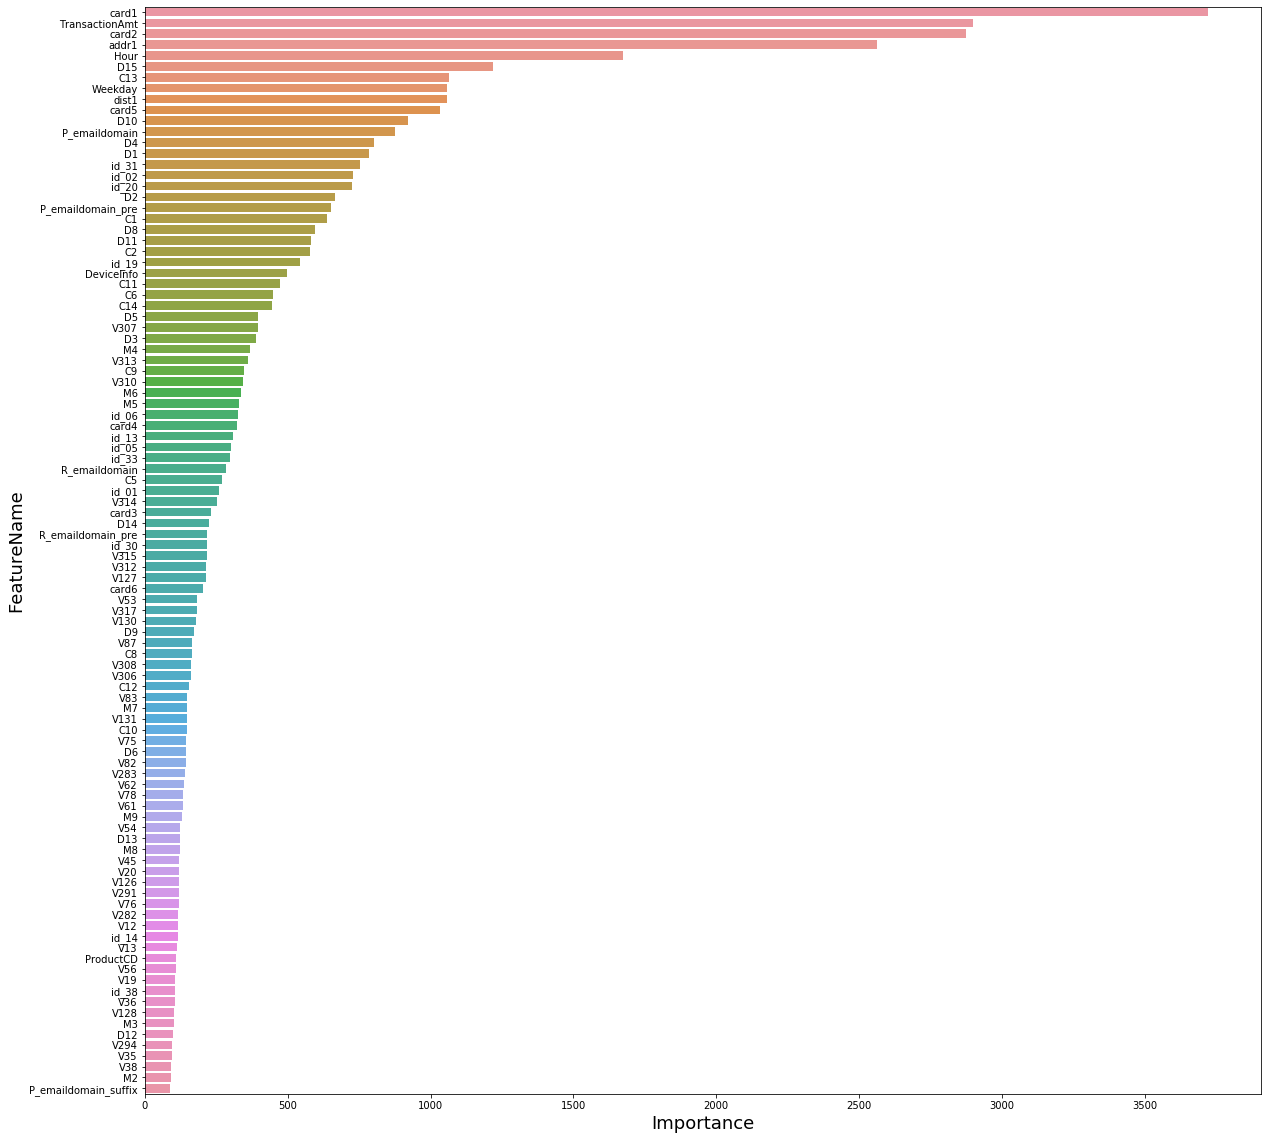

In [48]:
feature_importance_df = pd.concat([
    pd.Series(df_train.columns),
    pd.Series(lgb_model.feature_importance())], axis=1)
feature_importance_df.columns = ['featureName', 'importance']

# get top 100 features sorted by importance descending
temp = feature_importance_df.sort_values(by=['importance'], ascending=False).head(100)

plt.figure(figsize=(20, 20))
sns.barplot(x="importance", y="featureName", data=temp)
plt.xlabel("Importance", fontsize = 18)
plt.ylabel("FeatureName", fontsize = 18)
plt.show()